# Experiment 6

## Dataset
This data contains the name for 1895 games with 34 of ESRB rating content with the name and console as features for
each game.

ESRB ratings are meant to provide information on what age group a game is suitable for.

| Rating | Description     |
|--------|-----------------|
| RP     | Rating Pending  |
| EC     | Early Childhood |
| E      | Everyone        |
| E 10+  | Everyone 10+    |
| T      | Teen            |
| M      | Mature          |
| A      | Adult           |

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from misc_utilities import classification_metrics, plot_conf_matrix, plot_fit_curves

df = pd.read_csv("Video_games_esrb_rating.csv")
test_df = pd.read_csv("test_esrb.csv")

df = pd.concat([df, test_df])
old_df = df.copy()

## Analyse probleem
#### Wat is het probleem?
Our target feature is esrb_rating; we're trying to predict the age rating of a game.
#### Dimensies dataset?

In [89]:
print(f'Rows/Columns: {df.shape}')
print(f"Class distribution is: \n{df['esrb_rating'].value_counts()}\n")
print(df.isnull().sum())

Rows/Columns: (2395, 34)
Class distribution is: 
T     873
ET    529
E     516
M     477
Name: esrb_rating, dtype: int64

title                       0
console                     0
alcohol_reference           0
animated_blood              0
blood                       0
blood_and_gore              0
cartoon_violence            0
crude_humor                 0
drug_reference              0
fantasy_violence            0
intense_violence            0
language                    0
lyrics                      0
mature_humor                0
mild_blood                  0
mild_cartoon_violence       0
mild_fantasy_violence       0
mild_language               0
mild_lyrics                 0
mild_suggestive_themes      0
mild_violence               0
no_descriptors              0
nudity                      0
partial_nudity              0
sexual_content              0
sexual_themes               0
simulated_gambling          0
strong_janguage             0
strong_sexual_content       0
suggesti

#### Soorten data/features?
We have a categorical target feature, and for the rest entirely binary features.

## Methoden
#### Welke preprocessing is nodig?
Nauwelijks iets, behalve de titel eruit halen, en de target feature encoden.
#### Welke modellen ga je vergelijken?
Ik ga een decision tree vergelijken en een simpele dense neural network
#### Welke performance metric is passend?
We gaan de F1 score gebruiken, omdat accuracy niet passend is, en we geen voorkeur hebben voor precision/recall.

## Voorspelling
#### Welke classifier zal het beste zijn en waarom?
Decision tree zal het beter doen. Ze zullen beide waarschijnlijk overfitten, maar ik denk het neural netwerk veel meer
dan de decsion tree.
#### Welke hyperparameters zijn relevant en waarom?
Er zijn genoeg relevante, maar ivm smalle dataset denk ik niet dat ze van toepassing zijn.

## Process

In [90]:
df.drop('title', axis=1, inplace=True)

In [91]:
new_labels = pd.get_dummies(df['esrb_rating'])
df.pop('esrb_rating')

0       E
1      ET
2       M
3      ET
4       T
       ..
495     M
496     M
497     M
498     T
499     T
Name: esrb_rating, Length: 2395, dtype: object

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df, new_labels, train_size=0.8,  stratify=new_labels, random_state=5)

In [93]:
dt = DecisionTreeClassifier()

NN = Sequential()
NN.add(Dense(32, activation='relu'))
NN.add(Dense(4, activation='softmax'))
NN.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [94]:
history_DT = dt.fit(X_train, y_train)
history_NN = NN.fit(X_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
54/54 [==============================] - 1s 7ms/step - loss: 1.3751 - val_loss: 1.2392
Epoch 2/50
54/54 [==============================] - 0s 4ms/step - loss: 1.1910 - val_loss: 1.0640
Epoch 3/50
54/54 [==============================] - 0s 4ms/step - loss: 1.0098 - val_loss: 0.8836
Epoch 4/50
54/54 

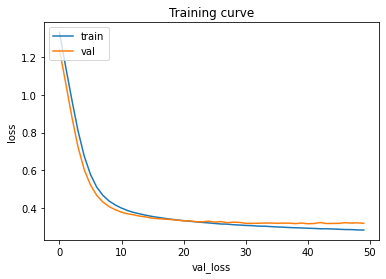

In [95]:
plot_fit_curves(history_NN, remove_first=False)

## Resultaten

In [96]:
dt_pred = dt.predict(X_test)
NN_pred = NN.predict(X_test)
NN_pred =  np.where(NN_pred > 0.5, 1, 0 )

In [97]:
print(classification_metrics(y_test, dt_pred, f1_weighting='weighted', multiclass=True)['F1'])
print(classification_metrics(y_test, NN_pred, f1_weighting='weighted', multiclass=True)['F1'])

0.8457651623472077
0.8550119416675088


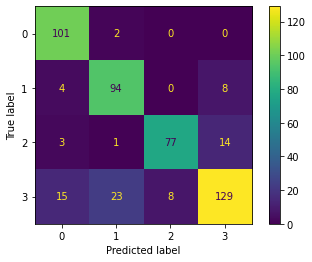

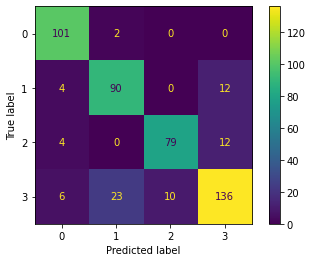

In [98]:
plot_conf_matrix(y_test.to_numpy().argmax(axis=1), dt_pred.argmax(axis=1))
plot_conf_matrix(y_test.to_numpy().argmax(axis=1), NN_pred.argmax(axis=1))

## Conclusie
#### Welke classifier had het beste resultaat?
NN heeft gewonnen met een F1 score van 85.6, vergeleken met DT's 84.6
#### Kwam dit overeen met de voorspelling? Waarom wel/niet?
Dit kwam niet overeen met mijn voorspelling. Ik had voorspeld dat NN het slechter zou doen omdat deze snel zou gaan
overfitten met deze dataset. Als je naar de learning curve kijkt zie je dat dit inderdaad gebeurt na een aantal
epochs.... maar blijkbaar is de cutoffpoint van de validation accuracy (het punt waarop hij niet meer beter wordt) laag
genoeg dat we het model vrij lang kunnen overfitten voordat het een slechtere score dan DT geeft. Wat ik namelijk ook
niet bedacht is dat DT ook snel de neiging heeft om te overfitten, dat is namelijke de hele reden dat Random Forest bestaat